## 一、逻辑回归识别手写字符

### 1.1 可视化数据

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [2]:
# 加载手写字符 mat 数据
def load_data(path, transpose = True):
    data = sio.loadmat(path)
    
    # (5000, 400), 5000 个样本实例，每个样本有 400 个特征
    X = data.get('X')
    
    # (5000, 1), 5000 个样本对应的真实标签值，这个实验是监督学习类型
    y = data.get('y')
    y = y.reshape(y.shape[0])
    
    # 把数组转为正确的方向
    if transpose:
        X = np.array([im.reshape((20, 20)).T for im in X])
        
        X = np.array([im.reshape(400) for im in X])
        
    return X, y

In [3]:
X, y = load_data('ex3data1.mat')

print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [4]:
# 绘图
def plot_an_image(image):
    fig, ax = plt.subplots(figsize = (1, 1))
    ax.matshow(image.reshape((20, 20)), cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

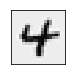

this shoule be 4


In [5]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()

print('this shoule be {}'.format(y[pick_one]))

In [7]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

In [6]:
#plot_100_image(X)

#plt.show()

### 1.2 准备数据

In [7]:
raw_X, raw_y = load_data('ex3data1.mat')

print(raw_X.shape)
print(raw_y.shape)

(5000, 400)
(5000,)


In [8]:
# 添加第一列全 1 向量
X = np.insert(raw_X, 0, values = np.ones(raw_X.shape[0]), axis = 1)
X.shape

(5000, 401)

In [9]:
# 把原标签中的每一类用一个行向量表示
y_matrix = []

# k = 1 ... 10
# 当 raw_y == k 时把对应位置的值设置为 1，否则为 0
for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))

# 因为 Matlab 下标从 1 开始，所以 raw_y 中用 10 表示标签 0
# 这里把标签 0 的行向量移动到第一行
y_matrix = [y_matrix[-1]] + y_matrix[:-1]

y = np.array(y_matrix)

# 10 行表示 0 - 9 这 10 个类别
y.shape

(10, 5000)

In [15]:
# 第一列表示 0，第二列表示 1，以此类推
y[0].shape

(5000,)

In [16]:
y[0]

array([1, 1, 1, ..., 0, 0, 0])

In [17]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

### 1.3 逻辑回归训练一维模型

In [45]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))


In [46]:
def regularized_cost(theta, X, y, l=1):
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term

In [47]:
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

In [48]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [49]:
def gradient(theta, X, y):
    '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)


In [50]:
def logistic_regression(X, y, l = 1):
    """逻辑回归函数
    args:
        X: 特征矩阵, (m, n + 1)，第一列为全 1 向量
        y: 标签矩阵, (m, )
        l: 正则化系数

    return: 训练的参数向量
    """
    # 保存训练的参数向量，维度为特征矩阵的列数，即特征数 + 1
    theta = np.zeros(X.shape[1])

    # 使用正则化代价和梯度训练
    res = opt.minimize(fun = regularized_cost,
                       x0 = theta,
                       args = (X, y, l),
                       method = 'TNC',
                       jac = regularized_gradient,
                       options = {'disp': True})
    
    # 得到最终训练参数
    final_theta = res.x

    return final_theta

In [51]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [52]:
theta_0 = logistic_regression(X, y[0])

In [57]:
print(theta_0.shape)

y_pred = predict(X, theta_0)

print('Accuracy = {}'.format(np.mean(y[0] == y_pred)))

(401,)
Accuracy = 0.9974


### 1.4 逻辑回归训练 K 维模型

In [59]:
# 训练 0 - 9 这 10 个类别的 theta_[0 -> 9] 参数向量
theta_k = np.array([logistic_regression(X, y[k]) for k in range(10)])
print(theta_k.shape)

(10, 401)


In [60]:
prob_matrix = sigmoid(X @ theta_k.T)

In [61]:
np.set_printoptions(suppress = True)
prob_matrix

array([[0.99577632, 0.        , 0.00053528, ..., 0.00006469, 0.00003912,
        0.00172187],
       [0.99834614, 0.0000001 , 0.00005607, ..., 0.00009684, 0.0000029 ,
        0.00008492],
       [0.99139772, 0.        , 0.00056828, ..., 0.00000654, 0.02653902,
        0.00197393],
       ...,
       [0.00000068, 0.04140121, 0.00320887, ..., 0.00012723, 0.00297489,
        0.70761228],
       [0.00001843, 0.00000013, 0.00000009, ..., 0.00164768, 0.06814687,
        0.86116757],
       [0.02879673, 0.        , 0.00012974, ..., 0.36626836, 0.00497918,
        0.14821854]])

In [66]:
# np.argmax 返回最大值的索引
y_pred = np.argmax(prob_matrix, axis = 1)

# (5000, 1)
print(y_pred.shape)

y_pred

(5000,)


array([0, 0, 0, ..., 9, 9, 7])

In [63]:
# (5000, 1)
y_answer = raw_y.copy()

# 用 0 代替 10
y_answer[y_answer == 10] = 0

In [64]:
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

